In [5]:
# import libs

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import torch.nn.functional as F

from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from utils import CustomDataset, JointTransform
from unet_model import UNet
from train import train_model
from scipy.optimize import curve_fit
from PIL import Image

import os
import logging
import time

ModuleNotFoundError: No module named 'unet_model'

In [1]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

NameError: name 'torch' is not defined

In [ ]:
# log part
def log_creater(logger_file_path):
    if not os.path.exists(logger_file_path):
        os.makedirs(logger_file_path)
    log_name = '{}.log'.format(time.strftime('%Y-%m-%d-%H-%M'))
    final_log_file = os.path.join(logger_file_path, log_name)

    logger = logging.getLogger()  # 设定日志对象
    logger.setLevel(logging.INFO)  # 设定日志等级

    file_handler = logging.FileHandler(final_log_file)  # 文件输出
    console_handler = logging.StreamHandler()  # 控制台输出

    formatter = logging.Formatter(
        "%(asctime)s %(levelname)s: %(message)s "
    )

    file_handler.setFormatter(formatter)  # 设置文件输出格式
    console_handler.setFormatter(formatter)  # 设施控制台输出格式
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    return logger

In [ ]:
# configurations

train_file_dir = 'C:\\Users\\LJY\\Desktop\\研一后\\2024kth比赛\\20240413\\testcode\\'
file_Resultdir='./Result_unet/'
fname_gt ='_IVIMParam.npy'
fname_tissue ='_TissueType.npy'
fname_noisyDWIk = '_NoisyDWIk.npy'
model_name=  "UNet"

logger = log_creater('./log/')

seg_parts = 8

set_seed(seed=10)

b_values = np.array([0, 5, 50, 100, 200, 500, 800, 1000])
loss_type = "L1L2"



#==========

learn_rate = 0.00015
batch_size = 8
time_point = 7
#==========

# Network
if time_point==7:
    b_values_no0 = torch.FloatTensor(b_values[1:])
else:
    b_values_no0 = torch.FloatTensor(b_values)
net = get_model(model_name, seg_parts, device)

optimizer = optim.AdamW(net.parameters(), lr = learn_rate, weight_decay=1e-3)  
# use crossentropyloss
criterion = nn.CrossEntropyLoss()
# # use focalloss
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2.0, alpha=None):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha  # 可选的 alpha，用于处理类别不平衡

#     def forward(self, outputs, targets):
#         # 使用 CrossEntropyLoss 计算每个样本的损失
#         ce_loss = F.cross_entropy(outputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)  # 计算概率

#         # 如果有 alpha，应用类别平衡
#         if self.alpha is not None:
#             at = self.alpha[targets]
#             ce_loss = at * ce_loss

#         # 计算 Focal Loss
#         focal_loss = ((1 - pt) ** self.gamma) * ce_loss
#         return focal_loss.mean()
# criterion = FocalLoss(gamma=2.0, alpha=torch.tensor([0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.3]).to(device))

In [6]:


print("seg parts = ", seg_parts)

train_transforms = Compose([
    RandFlip(spatial_axis=[0], prob=0.5),
    RandFlip(spatial_axis=[1], prob=0.5),
    # RandRotate(range_x=np.pi/12, prob=0.2)
    # RandGaussianNoise(prob=0.5, mean=0.0, std=0.01),
    # RandAdjustContrast(prob=0.3, gamma=(0.9, 1.1)),
    # ScaleIntensity(minv=0.9, maxv=1.1)
])

breast_data_train = BreastDataset_seg(time_point,train_file_dir,train_val="train",one_or_twoDim=False,denoise=if_denoise, seg_num=seg_parts, transform=None)
breast_data_val = BreastDataset_seg(time_point,train_file_dir,train_val="val",one_or_twoDim=False,denoise=if_denoise, seg_num=seg_parts)


trainloader = utils.DataLoader(breast_data_train ,
                                batch_size = batch_size, 
                                shuffle = False,
                                num_workers = 0,
                                drop_last = True)

valloader = utils.DataLoader(breast_data_val,
                                batch_size = 1, 
                                shuffle = False,
                                num_workers = 0,
                                drop_last = False)     

seg parts =  8


torch.Size([1, 7, 200, 200])


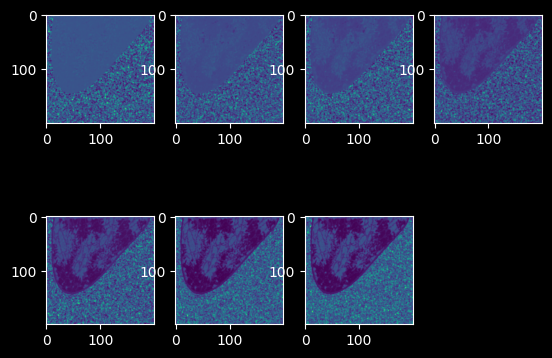

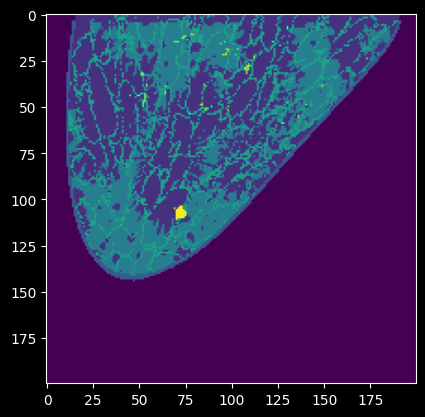

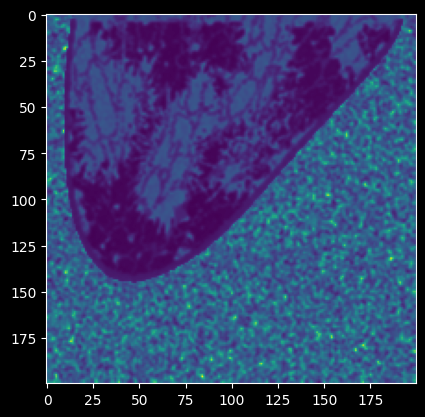

In [7]:
testimg, testlabel = next(iter(valloader))

print(testimg.shape)
plt.figure()

for i in range(7):
    plt.subplot(2,4,i+1)
    plt.imshow(testimg[0,i,:,:])
plt.show()

plt.figure()

for i in range(7):
    plt.imshow(testlabel[0,:,:])
plt.show()

plt.figure()

for i in range(7):
    plt.imshow(testimg[0,i,:,:])
plt.show()


In [45]:
epochs = 15
model, results = train_seg(net, trainloader, valloader, criterion, optimizer, device, num_epochs = epochs, logger = logger)

==epoch 1 start==


100%|██████████| 87/87 [00:35<00:00,  2.42it/s]


Epoch 1/15:
Train Loss: 0.1770
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:05<00:00, 38.44it/s]
2024-11-05 01:46:47,843 INFO: loss: 0.1608 dice: 0.5970 
2024-11-05 01:46:47,843 INFO: loss: 0.1608 dice: 0.5970 
2024-11-05 01:46:47,843 INFO: loss: 0.1608 dice: 0.5970 
2024-11-05 01:46:47,843 INFO: loss: 0.1608 dice: 0.5970 


0.5969681906700134
vall [9.9966371e-01 9.4755179e-01 9.6734077e-01 9.4221067e-01 8.0310977e-01
 7.5000137e-02 4.0868144e-02 3.3003129e-08]
Val Loss: 0.1608, Val Accuracy: 0.5970
==epoch 2 start==


100%|██████████| 87/87 [00:36<00:00,  2.38it/s]


Epoch 2/15:
Train Loss: 0.1447
==epoch 3 start==


100%|██████████| 87/87 [00:52<00:00,  1.66it/s]


Epoch 3/15:
Train Loss: 0.1207
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:16<00:00, 12.41it/s]
2024-11-05 01:48:32,980 INFO: loss: 0.1150 dice: 0.6104 
2024-11-05 01:48:32,980 INFO: loss: 0.1150 dice: 0.6104 
2024-11-05 01:48:32,980 INFO: loss: 0.1150 dice: 0.6104 
2024-11-05 01:48:32,980 INFO: loss: 0.1150 dice: 0.6104 


0.6103512838482856
vall [9.997938e-01 9.651638e-01 9.658729e-01 9.525198e-01 8.331157e-01
 7.500014e-02 9.134426e-02 3.300313e-08]
Val Loss: 0.1150, Val Accuracy: 0.6104
==epoch 4 start==


100%|██████████| 87/87 [00:55<00:00,  1.55it/s]


Epoch 4/15:
Train Loss: 0.1027
==epoch 5 start==


100%|██████████| 87/87 [00:57<00:00,  1.51it/s]


Epoch 5/15:
Train Loss: 0.0886
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:15<00:00, 12.82it/s]
2024-11-05 01:50:42,460 INFO: loss: 0.0845 dice: 0.6492 
2024-11-05 01:50:42,460 INFO: loss: 0.0845 dice: 0.6492 
2024-11-05 01:50:42,460 INFO: loss: 0.0845 dice: 0.6492 
2024-11-05 01:50:42,460 INFO: loss: 0.0845 dice: 0.6492 


0.6492361605167389
vall [9.9986845e-01 9.7054702e-01 9.7174937e-01 9.7051179e-01 8.8781279e-01
 7.5000137e-02 3.1839970e-01 3.3003129e-08]
Val Loss: 0.0845, Val Accuracy: 0.6492
==epoch 6 start==


100%|██████████| 87/87 [00:54<00:00,  1.60it/s]


Epoch 6/15:
Train Loss: 0.0777
==epoch 7 start==


100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Epoch 7/15:
Train Loss: 0.0695
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:15<00:00, 12.80it/s]
2024-11-05 01:52:41,728 INFO: loss: 0.0717 dice: 0.7625 
2024-11-05 01:52:41,728 INFO: loss: 0.0717 dice: 0.7625 
2024-11-05 01:52:41,728 INFO: loss: 0.0717 dice: 0.7625 
2024-11-05 01:52:41,728 INFO: loss: 0.0717 dice: 0.7625 


0.7625478065013885
vall [0.9998712  0.9686502  0.9775854  0.97940445 0.90019387 0.07500014
 0.5317647  0.667912  ]
Val Loss: 0.0717, Val Accuracy: 0.7625
==epoch 8 start==


100%|██████████| 87/87 [00:54<00:00,  1.59it/s]


Epoch 8/15:
Train Loss: 0.0622
==epoch 9 start==


100%|██████████| 87/87 [00:59<00:00,  1.47it/s]


Epoch 9/15:
Train Loss: 0.0556
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:04<00:00, 40.26it/s]
2024-11-05 01:54:40,892 INFO: loss: 0.0548 dice: 0.7878 
2024-11-05 01:54:40,892 INFO: loss: 0.0548 dice: 0.7878 
2024-11-05 01:54:40,892 INFO: loss: 0.0548 dice: 0.7878 
2024-11-05 01:54:40,892 INFO: loss: 0.0548 dice: 0.7878 


0.7877741202712059
vall [0.9999189  0.9795437  0.9814088  0.9814339  0.9234576  0.07500014
 0.6285648  0.7328657 ]
Val Loss: 0.0548, Val Accuracy: 0.7878
==epoch 10 start==


100%|██████████| 87/87 [00:53<00:00,  1.63it/s]


Epoch 10/15:
Train Loss: 0.0504
==epoch 11 start==


100%|██████████| 87/87 [00:54<00:00,  1.60it/s]


Epoch 11/15:
Train Loss: 0.0461
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:04<00:00, 41.07it/s]
2024-11-05 01:56:33,541 INFO: loss: 0.0454 dice: 0.7955 
2024-11-05 01:56:33,541 INFO: loss: 0.0454 dice: 0.7955 
2024-11-05 01:56:33,541 INFO: loss: 0.0454 dice: 0.7955 
2024-11-05 01:56:33,541 INFO: loss: 0.0454 dice: 0.7955 


0.795513986647129
vall [0.9999337  0.98140496 0.98211205 0.98568994 0.93566453 0.07500014
 0.6977525  0.70655394]
Val Loss: 0.0454, Val Accuracy: 0.7955
==epoch 12 start==


100%|██████████| 87/87 [00:52<00:00,  1.65it/s]


Epoch 12/15:
Train Loss: 0.0422
==epoch 13 start==


100%|██████████| 87/87 [00:54<00:00,  1.61it/s]


Epoch 13/15:
Train Loss: 0.0388
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:05<00:00, 39.47it/s]
2024-11-05 01:58:25,795 INFO: loss: 0.0390 dice: 0.8138 
2024-11-05 01:58:25,795 INFO: loss: 0.0390 dice: 0.8138 
2024-11-05 01:58:25,795 INFO: loss: 0.0390 dice: 0.8138 
2024-11-05 01:58:25,795 INFO: loss: 0.0390 dice: 0.8138 


0.8138172477483749
vall [0.99993604 0.98230994 0.9836929  0.98782617 0.94227374 0.07500014
 0.74319845 0.79630005]
Val Loss: 0.0390, Val Accuracy: 0.8138
==epoch 14 start==


100%|██████████| 87/87 [00:56<00:00,  1.54it/s]


Epoch 14/15:
Train Loss: 0.0360
==epoch 15 start==


100%|██████████| 87/87 [00:54<00:00,  1.60it/s]


Epoch 15/15:
Train Loss: 0.0335
<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 200/200 [00:05<00:00, 39.96it/s]
2024-11-05 02:00:21,892 INFO: loss: 0.0344 dice: 0.8228 
2024-11-05 02:00:21,892 INFO: loss: 0.0344 dice: 0.8228 
2024-11-05 02:00:21,892 INFO: loss: 0.0344 dice: 0.8228 
2024-11-05 02:00:21,892 INFO: loss: 0.0344 dice: 0.8228 


0.8228303647041321
vall [0.9999511  0.98343307 0.9835074  0.9890537  0.9463343  0.07500014
 0.7857269  0.819636  ]
Val Loss: 0.0344, Val Accuracy: 0.8228


torch.Size([200, 200])


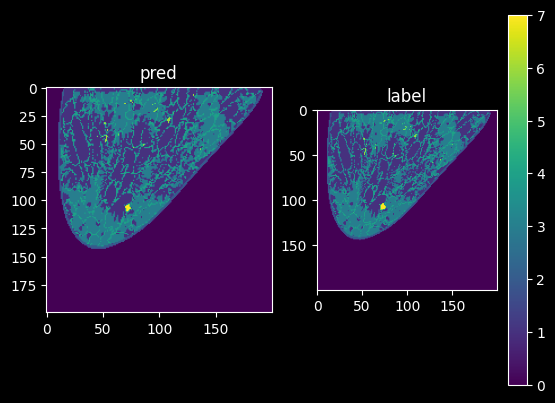

In [70]:
# vali
img, label = next(iter(valloader))

pred = model(img.float().to(device))

pred = pred.argmax(1).squeeze().cpu()
label = label.squeeze().cpu()
print(pred.shape)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(pred)
plt.title("pred")
plt.subplot(1,2,2)
plt.imshow(label)
plt.title("label")
plt.colorbar()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weightsa.pth')

In [ ]:
# dice = multiclass_dice_coeff(pred, label)
# print(dice)

import torch
import torch.nn.functional as F

def multiclass_dice_score(preds, labels, num_classes, eps=1e-6):

    labels_one_hot = F.one_hot(labels, num_classes).permute(0, 3, 1, 2)
    
    dice_scores = []
    
    for cls in range(num_classes):
        pred_cls = preds[:, cls, :, :]
        label_cls = labels_one_hot[:, cls, :, :]
        
        intersection = (pred_cls * label_cls).sum(dim=(1, 2))
        union = pred_cls.sum(dim=(1, 2)) + label_cls.sum(dim=(1, 2))
        
        dice = (2 * intersection + eps) / (union + eps)
        dice_scores.append(dice.mean().item())
    
    return sum(dice_scores) / num_classes

num_classes = seg_parts  

p = F.one_hot(pred, seg_parts).permute(0, 3, 1, 2).float()

dice_score = multiclass_dice_score(pred, label, num_classes)
print("Multi-class Dice Score:", dice_score)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

In [8]:
# vali

checkpoint = torch.load('model_weights_8_21_34_50_l2_1e-3.pth')
net.load_state_dict(checkpoint)
net.eval()

breast_data_inf = BreastDataset_seg(time_point,train_file_dir,train_val="inf",one_or_twoDim=False,denoise=if_denoise, seg_num=seg_parts)


infloader = utils.DataLoader(breast_data_inf ,
                                batch_size = 1, 
                                shuffle = False,
                                num_workers = 0,
                                drop_last = False)

self.data_index [900. 901. 902. 903. 904. 905. 906. 907. 908. 909. 910. 911. 912. 913.
 914. 915. 916. 917. 918. 919. 920. 921. 922. 923. 924. 925. 926. 927.
 928. 929. 930. 931. 932. 933. 934. 935. 936. 937. 938. 939. 940. 941.
 942. 943. 944. 945. 946. 947. 948. 949. 950. 951. 952. 953. 954. 955.
 956. 957. 958. 959. 960. 961. 962. 963. 964. 965. 966. 967. 968. 969.
 970. 971. 972. 973. 974. 975. 976. 977. 978. 979. 980. 981. 982. 983.
 984. 985. 986. 987. 988. 989. 990. 991. 992. 993. 994. 995. 996. 997.
 998. 999.]


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [11]:
import train

inf_loss, inf_accuracy, inf_dicelist = train.check_accuracy(net, infloader, criterion, device)
print(inf_loss)
print(inf_dicelist)

<class 'torch.utils.data.dataloader.DataLoader'>


  0%|          | 0/100 [00:00<?, ?it/s]

(1, 200, 200) (1, 200, 200)


ValueError: unknown is not supported

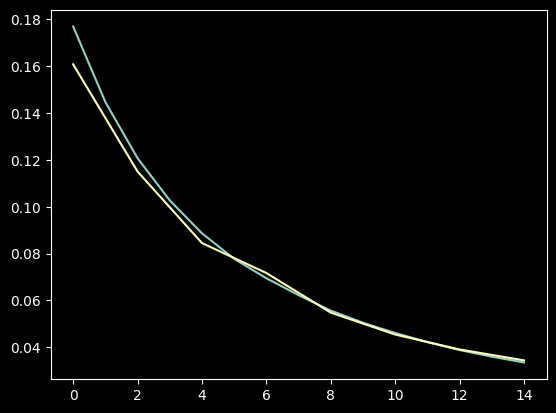

In [50]:
plt.plot(range(epochs), results['train_loss'])
plt.plot(range(0,epochs,2), results['val_loss'])
plt.show()